Bayesian Convolutional Neural Network untuk Deteksi Diabetic Retinopathy
Dataset: Diabetic Retinopathy 224x224 (2019) from Kaggle
Framework: TensorFlow/Keras dengan Monte Carlo Dropout

In [36]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import os

In [2]:
# ============================================================================
# KAGGLE API SETUP & DATASET DOWNLOAD
# ============================================================================
print("\n" + "=" * 80)
print("STEP 2: Setting up Kaggle API and Downloading Dataset")
print("=" * 80)

# Setup Kaggle credentials
kaggle_credentials = {
    "username": 'algyngenget',
    "key": 'KGAT_5a2afb599eaaf252417f1165565abc17'
}

os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_credentials, f)
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# Download dataset
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-2019-data

# Extract dataset
!unzip -q diabetic-retinopathy-224x224-2019-data.zip -d ./dataset
print("✓ Dataset downloaded and extracted successfully!")



STEP 2: Setting up Kaggle API and Downloading Dataset
Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data
License(s): CC0-1.0
 63% 150M/238M [00:00<00:00, 1.57GB/s]
100% 238M/238M [00:00<00:00, 947MB/s] 
✓ Dataset downloaded and extracted successfully!


In [16]:
# ============================================================================
# STEP 1: LOAD DATA (SAMA)
# ============================================================================
print("="*70)
print("STEP 1: LOADING DATA")
print("="*70)

image_dir = 'dataset/colored_images'
filename = []
label = []

for dir_name in os.listdir(image_dir):
    for file in os.listdir(os.path.join(image_dir, dir_name)):
        filename.append(os.path.join(dir_name, file))
        label.append(dir_name)

df = pd.DataFrame({"filename": filename, "label": label})
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total images: {len(df_shuffled)}")
print("\n📊 Original class distribution:")
print(df_shuffled['label'].value_counts())

STEP 1: LOADING DATA
Total images: 3662

📊 Original class distribution:
label
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64


In [17]:
# ============================================================================
# 🔑 STEP 2: SPLIT DULU (JANGAN OVERSAMPLE!)
# ============================================================================
print("\n" + "="*70)
print("STEP 2: SPLITTING DATA (NO OVERSAMPLING!)")
print("="*70)

# Split 1: Train vs (Val + Test)
train_df, temp_df = train_test_split(
    df_shuffled,
    test_size=0.30,
    random_state=42,
    stratify=df_shuffled['label']
)

# Split 2: Val vs Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df['label']
)

print(f"\nTrain: {len(train_df)} samples")
print(f"Val:   {len(val_df)} samples")
print(f"Test:  {len(test_df)} samples")

print(f"\n📋 Train distribution (imbalanced - ini OK!):")
print(train_df['label'].value_counts())


STEP 2: SPLITTING DATA (NO OVERSAMPLING!)

Train: 2563 samples
Val:   549 samples
Test:  550 samples

📋 Train distribution (imbalanced - ini OK!):
label
No_DR             1263
Moderate           699
Mild               259
Proliferate_DR     207
Severe             135
Name: count, dtype: int64


In [18]:
# ============================================================================
# 🔑 STEP 3: COMPUTE CLASS WEIGHTS (INI KUNCI!)
# ============================================================================
print("\n" + "="*70)
print("STEP 3: COMPUTING CLASS WEIGHTS")
print("="*70)

# Class order harus match dengan generator classes
class_order = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

# Compute class weights
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.array(class_order),
    y=train_df['label']
)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("\n🎯 Class Weights (higher = minority class):")
for i, (class_name, weight) in enumerate(zip(class_order, class_weights_array)):
    count = len(train_df[train_df['label'] == class_name])
    print(f"   {i}. {class_name:15s}: {weight:.2f} (count: {count})")


STEP 3: COMPUTING CLASS WEIGHTS

🎯 Class Weights (higher = minority class):
   0. No_DR          : 0.41 (count: 1263)
   1. Mild           : 1.98 (count: 259)
   2. Moderate       : 0.73 (count: 699)
   3. Severe         : 3.80 (count: 135)
   4. Proliferate_DR : 2.48 (count: 207)


In [19]:
# ============================================================================
# STEP 4: CREATE DATA GENERATORS
# ============================================================================
print("\n" + "="*70)
print("STEP 4: CREATING DATA GENERATORS")
print("="*70)

# Train generator - dengan augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Val/Test generator - hanya rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_order,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_order,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_order,
    shuffle=False
)

print(f"✅ Generators created:")
print(f"   Train: {len(train_generator)} batches")
print(f"   Val:   {len(val_generator)} batches")
print(f"   Test:  {len(test_generator)} batches")


STEP 4: CREATING DATA GENERATORS
Found 2563 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
✅ Generators created:
   Train: 81 batches
   Val:   18 batches
   Test:  18 batches


In [57]:
# 1. Download weights manually:
!wget https://storage.googleapis.com/tensorflow/keras-applications/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-12-23 04:01:41--  https://storage.googleapis.com/tensorflow/keras-applications/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29084464 (28M) [application/octet-stream]
Saving to: ‘densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5’

densenet121_weights 100%[===================>]  27.74M  11.9MB/s    in 2.3s    

2025-12-23 04:01:44 (11.9 MB/s) - ‘densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [29084464/29084464]



In [59]:
# 2. Copy ke Keras cache:
!mkdir -p ~/.keras/models
!mv densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5 ~/.keras/models/

In [60]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

print("\n3️⃣  Building Bayesian CNN with verified DenseNet121...")

def build_bayesian_cnn_densenet(dropout_rate=0.5, verbose=True):
    """
    Build Bayesian CNN with VERIFIED DenseNet121 pretrained weights
    """

    if verbose:
        print(f"\n   Loading DenseNet121 backbone...")

    # Load DenseNet121 with ImageNet weights
    base_model = DenseNet121(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling=None
    )

    if verbose:
        print(f"   ✅ Backbone loaded: {len(base_model.layers)} layers")
        print(f"   Total params: {base_model.count_params():,}")

    # VERIFY weights loaded - find first layer with weights
    weights_verified = False
    for i, layer in enumerate(base_model.layers):
        weights = layer.get_weights()
        if len(weights) > 0:  # Layer has weights
            weight_mean = np.abs(weights[0]).mean()

            if weight_mean < 0.001:
                raise ValueError(f"❌ DenseNet weights not loaded! Mean weight too small in layer {i}.")

            if verbose:
                print(f"   ✅ Weights verified (layer {i}: {layer.name}, mean: {weight_mean:.6f})")

            weights_verified = True
            break

    if not weights_verified:
        raise ValueError("❌ Could not find any layer with weights to verify!")

    # Freeze early layers, unfreeze last 50 layers for fine-tuning
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    for layer in base_model.layers[-50:]:
        layer.trainable = True

    trainable_count = sum([layer.trainable for layer in base_model.layers])

    if verbose:
        print(f"   Trainable layers: {trainable_count}/{len(base_model.layers)}")

    # Build classification head
    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = BatchNormalization(name='bn_1')(x)

    # Dense layers with MC Dropout
    x = Dense(512, activation='relu', name='dense_1')(x)
    x = Dropout(dropout_rate, name='bayesian_dropout_1')(x)

    x = Dense(256, activation='relu', name='dense_2')(x)
    x = Dropout(dropout_rate, name='bayesian_dropout_2')(x)

    x = Dense(128, activation='relu', name='dense_3')(x)
    x = Dropout(dropout_rate, name='bayesian_dropout_3')(x)

    # Output layer
    output = Dense(5, activation='softmax', name='output')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=output, name='Bayesian_DenseNet121')

    if verbose:
        print(f"\n   ✅ Model built successfully!")
        print(f"   Total layers: {len(model.layers)}")
        print(f"   Total params: {model.count_params():,}")

        # Calculate trainable vs non-trainable params
        trainable_params = sum([np.prod(v.shape) for v in model.trainable_weights])
        non_trainable_params = sum([np.prod(v.shape) for v in model.non_trainable_weights])

        print(f"   Trainable params: {trainable_params:,}")
        print(f"   Non-trainable params: {non_trainable_params:,}")

        # Calculate model size estimate
        param_count = model.count_params()
        estimated_size_mb = (param_count * 4) / (1024 * 1024)  # 4 bytes per param (float32)
        print(f"   Estimated size: ~{estimated_size_mb:.1f} MB")

        if estimated_size_mb < 80:
            print(f"   ⚠️  WARNING: Estimated size too small!")
            print(f"   Expected: 100-150 MB")

    return model

# Build model
model = build_bayesian_cnn_densenet(dropout_rate=0.5, verbose=True)

# Compile
print("\n4️⃣  Compiling model...")
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("   ✅ Model compiled!")


3️⃣  Building Bayesian CNN with verified DenseNet121...

   Loading DenseNet121 backbone...
   ✅ Backbone loaded: 427 layers
   Total params: 7,037,504
   ✅ Weights verified (layer 2: conv1_conv, mean: 0.084703)
   Trainable layers: 50/427

   ✅ Model built successfully!
   Total layers: 436
   Total params: 7,731,269
   Trainable params: 1,767,365
   Non-trainable params: 5,963,904
   Estimated size: ~29.5 MB
   ⚠️  WARNING: Estimated size too small!
   Expected: 100-150 MB

4️⃣  Compiling model...
   ✅ Model compiled!


In [61]:
# ============================================================================
# STEP 6: SETUP CALLBACKS
# ============================================================================
print("\n" + "="*70)
print("STEP 6: SETTING UP CALLBACKS")
print("="*70)

os.makedirs('models', exist_ok=True)

callbacks = [
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=15,  # Increased patience
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        'models/best_bayesian_densenet_v2.h5',  # New filename
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("✅ Callbacks configured")


STEP 6: SETTING UP CALLBACKS
✅ Callbacks configured


In [62]:
# ============================================================================
# 🔑 STEP 7: TRAINING DENGAN CLASS WEIGHTS!
# ============================================================================
print("\n" + "="*70)
print("STEP 7: TRAINING MODEL WITH CLASS WEIGHTS")
print("="*70)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks,
    class_weight=class_weight_dict,  # 🔑 KUNCI: Class weights!
    verbose=1
)

print("\n✅ Training completed!")
print(f"   Epochs trained: {len(history.history['loss'])}")
print(f"   Best val_loss: {min(history.history['val_loss']):.4f}")
print(f"   Best val_accuracy: {max(history.history['val_accuracy']):.4f}")


STEP 7: TRAINING MODEL WITH CLASS WEIGHTS
Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.3539 - loss: 2.1271
Epoch 1: val_loss improved from inf to 1.29451, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.3541 - loss: 2.1253 - val_accuracy: 0.5373 - val_loss: 1.2945 - learning_rate: 1.0000e-04
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.4183 - loss: 1.6337
Epoch 2: val_loss improved from 1.29451 to 1.08362, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 483ms/step - accuracy: 0.4188 - loss: 1.6336 - val_accuracy: 0.5756 - val_loss: 1.0836 - learning_rate: 1.0000e-04
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.4585 - loss: 1.5507
Epoch 3: val_loss improved from 1.08362 to 0.96195, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 484ms/step - accuracy: 0.4585 - loss: 1.5508 - val_accuracy: 0.5883 - val_loss: 0.9620 - learning_rate: 1.0000e-04
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.4955 - loss: 1.5061
Epoch 4: val_loss improved from 0.96195 to 0.89506, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 486ms/step - accuracy: 0.4957 - loss: 1.5053 - val_accuracy: 0.6029 - val_loss: 0.8951 - learning_rate: 1.0000e-04
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.5419 - loss: 1.3742
Epoch 5: val_loss improved from 0.89506 to 0.86959, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 485ms/step - accuracy: 0.5418 - loss: 1.3746 - val_accuracy: 0.6284 - val_loss: 0.8696 - learning_rate: 1.0000e-04
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.5379 - loss: 1.3217
Epoch 6: val_loss improved from 0.86959 to 0.85984, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 485ms/step - accuracy: 0.5380 - loss: 1.3218 - val_accuracy: 0.6047 - val_loss: 0.8598 - learning_rate: 1.0000e-04
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.5553 - loss: 1.3046
Epoch 7: val_loss improved from 0.85984 to 0.84004, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 483ms/step - accuracy: 0.5552 - loss: 1.3048 - val_accuracy: 0.6084 - val_loss: 0.8400 - learning_rate: 1.0000e-04
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.5624 - loss: 1.3341
Epoch 8: val_loss improved from 0.84004 to 0.83295, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 484ms/step - accuracy: 0.5623 - loss: 1.3338 - val_accuracy: 0.6211 - val_loss: 0.8329 - learning_rate: 1.0000e-04
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.5798 - loss: 1.2542
Epoch 9: val_loss improved from 0.83295 to 0.82760, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 481ms/step - accuracy: 0.5798 - loss: 1.2543 - val_accuracy: 0.5993 - val_loss: 0.8276 - learning_rate: 1.0000e-04
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.5892 - loss: 1.1927
Epoch 10: val_loss improved from 0.82760 to 0.82529, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 496ms/step - accuracy: 0.5891 - loss: 1.1929 - val_accuracy: 0.6084 - val_loss: 0.8253 - learning_rate: 1.0000e-04
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.5854 - loss: 1.2505
Epoch 11: val_loss improved from 0.82529 to 0.80881, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 479ms/step - accuracy: 0.5854 - loss: 1.2498 - val_accuracy: 0.6157 - val_loss: 0.8088 - learning_rate: 1.0000e-04
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.5930 - loss: 1.1956
Epoch 12: val_loss improved from 0.80881 to 0.78366, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 479ms/step - accuracy: 0.5930 - loss: 1.1955 - val_accuracy: 0.6339 - val_loss: 0.7837 - learning_rate: 1.0000e-04
Epoch 13/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5987 - loss: 1.1114
Epoch 13: val_loss improved from 0.78366 to 0.77009, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 476ms/step - accuracy: 0.5988 - loss: 1.1121 - val_accuracy: 0.6430 - val_loss: 0.7701 - learning_rate: 1.0000e-04
Epoch 14/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6251 - loss: 1.1137
Epoch 14: val_loss improved from 0.77009 to 0.75286, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 478ms/step - accuracy: 0.6250 - loss: 1.1140 - val_accuracy: 0.6503 - val_loss: 0.7529 - learning_rate: 1.0000e-04
Epoch 15/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6062 - loss: 1.0989
Epoch 15: val_loss did not improve from 0.75286
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 467ms/step - accuracy: 0.6063 - loss: 1.0992 - val_accuracy: 0.6448 - val_loss: 0.7558 - learning_rate: 1.0000e-04
Epoch 16/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6317 - loss: 1.1243
Epoch 16: val_loss improved from 0.75286 to 0.74824, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 489ms/step - accuracy: 0.6315 - loss: 1.1246 - val_accuracy: 0.6485 - val_loss: 0.7482 - learning_rate: 1.0000e-04
Epoch 17/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6134 - loss: 1.1413
Epoch 17: val_loss improved from 0.74824 to 0.73696, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 477ms/step - accuracy: 0.6135 - loss: 1.1408 - val_accuracy: 0.6503 - val_loss: 0.7370 - learning_rate: 1.0000e-04
Epoch 18/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6387 - loss: 1.0794
Epoch 18: val_loss improved from 0.73696 to 0.73159, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 479ms/step - accuracy: 0.6386 - loss: 1.0794 - val_accuracy: 0.6612 - val_loss: 0.7316 - learning_rate: 1.0000e-04
Epoch 19/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6193 - loss: 1.0838
Epoch 19: val_loss improved from 0.73159 to 0.72853, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 478ms/step - accuracy: 0.6194 - loss: 1.0839 - val_accuracy: 0.6576 - val_loss: 0.7285 - learning_rate: 1.0000e-04
Epoch 20/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6361 - loss: 1.0976
Epoch 20: val_loss improved from 0.72853 to 0.72738, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 479ms/step - accuracy: 0.6361 - loss: 1.0972 - val_accuracy: 0.6648 - val_loss: 0.7274 - learning_rate: 1.0000e-04
Epoch 21/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.6403 - loss: 1.0760
Epoch 21: val_loss improved from 0.72738 to 0.71954, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 478ms/step - accuracy: 0.6404 - loss: 1.0759 - val_accuracy: 0.6721 - val_loss: 0.7195 - learning_rate: 1.0000e-04
Epoch 22/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6723 - loss: 1.0450
Epoch 22: val_loss improved from 0.71954 to 0.71893, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 479ms/step - accuracy: 0.6723 - loss: 1.0451 - val_accuracy: 0.6667 - val_loss: 0.7189 - learning_rate: 1.0000e-04
Epoch 23/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.6674 - loss: 1.0134
Epoch 23: val_loss improved from 0.71893 to 0.71511, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 484ms/step - accuracy: 0.6672 - loss: 1.0136 - val_accuracy: 0.6721 - val_loss: 0.7151 - learning_rate: 1.0000e-04
Epoch 24/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.6721 - loss: 0.9743
Epoch 24: val_loss improved from 0.71511 to 0.69049, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 475ms/step - accuracy: 0.6721 - loss: 0.9747 - val_accuracy: 0.6758 - val_loss: 0.6905 - learning_rate: 1.0000e-04
Epoch 25/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6567 - loss: 1.0631
Epoch 25: val_loss did not improve from 0.69049
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 467ms/step - accuracy: 0.6568 - loss: 1.0622 - val_accuracy: 0.6812 - val_loss: 0.6913 - learning_rate: 1.0000e-04
Epoch 26/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7037 - loss: 0.9187
Epoch 26: val_loss did not improve from 0.69049
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.7035 - loss: 0.9192 - val_accuracy: 0.6703 - val_loss: 0.7026 - learning_rate: 1.0000e-04
Epoch 27/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6719 - loss: 1.0296
Epoch 27: val_loss improved from 0.69049 to 0.68738, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 482ms/step - accuracy: 0.6721 - loss: 1.0289 - val_accuracy: 0.6885 - val_loss: 0.6874 - learning_rate: 1.0000e-04
Epoch 28/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6793 - loss: 1.0003
Epoch 28: val_loss did not improve from 0.68738
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 464ms/step - accuracy: 0.6792 - loss: 1.0002 - val_accuracy: 0.6685 - val_loss: 0.6953 - learning_rate: 1.0000e-04
Epoch 29/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.6908 - loss: 0.9394
Epoch 29: val_loss did not improve from 0.68738
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 464ms/step - accuracy: 0.6907 - loss: 0.9393 - val_accuracy: 0.6885 - val_loss: 0.6948 - learning_rate: 1.0000e-04
Epoch 30/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6890 - loss: 0.9999
Epoch 30: val_loss did not improve from 0.68738
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 466ms/step - accuracy: 0.6890 - loss: 0.9997 - val_accuracy: 0.6940 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 31

81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 474ms/step - accuracy: 0.7003 - loss: 0.9319 - val_accuracy: 0.6831 - val_loss: 0.6863 - learning_rate: 1.0000e-04
Epoch 32/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6887 - loss: 0.8934
Epoch 32: val_loss improved from 0.68627 to 0.68342, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 481ms/step - accuracy: 0.6887 - loss: 0.8937 - val_accuracy: 0.6885 - val_loss: 0.6834 - learning_rate: 1.0000e-04
Epoch 33/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.7060 - loss: 0.8935
Epoch 33: val_loss improved from 0.68342 to 0.68329, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 488ms/step - accuracy: 0.7060 - loss: 0.8935 - val_accuracy: 0.6940 - val_loss: 0.6833 - learning_rate: 1.0000e-04
Epoch 34/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.7101 - loss: 0.8975
Epoch 34: val_loss improved from 0.68329 to 0.65888, saving model to models/best_bayesian_densenet_v2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 476ms/step - accuracy: 0.7100 - loss: 0.8978 - val_accuracy: 0.7122 - val_loss: 0.6589 - learning_rate: 1.0000e-04
Epoch 35/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7373 - loss: 0.8274
Epoch 35: val_loss did not improve from 0.65888
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 465ms/step - accuracy: 0.7371 - loss: 0.8284 - val_accuracy: 0.6849 - val_loss: 0.6875 - learning_rate: 1.0000e-04
Epoch 36/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7069 - loss: 0.8694
Epoch 36: val_loss did not improve from 0.65888
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 473ms/step - accuracy: 0.7068 - loss: 0.8696 - val_accuracy: 0.7031 - val_loss: 0.6680 - learning_rate: 1.0000e-04
Epoch 37/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7249 - loss: 0.9302
Epoch 37: val_loss did not improve from 0.65888
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 465ms/step - accuracy: 0.7248 - loss: 0.9300 - val_accuracy: 0.6976 - val_loss: 0.6782 - learning_rate: 1.0000e-04
Epoch 38

81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 479ms/step - accuracy: 0.7387 - loss: 0.8005 - val_accuracy: 0.7286 - val_loss: 0.6411 - learning_rate: 5.0000e-05
Epoch 44/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7181 - loss: 0.8385
Epoch 44: val_loss did not improve from 0.64108
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 460ms/step - accuracy: 0.7183 - loss: 0.8381 - val_accuracy: 0.7250 - val_loss: 0.6626 - learning_rate: 5.0000e-05
Epoch 45/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7431 - loss: 0.7640
Epoch 45: val_loss did not improve from 0.64108
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 461ms/step - accuracy: 0.7431 - loss: 0.7644 - val_accuracy: 0.7250 - val_loss: 0.6734 - learning_rate: 5.0000e-05
Epoch 46/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.7235 - loss: 0.9026
Epoch 46: val_loss did not improve from 0.64108
81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.7235 - loss: 0.9017 - val_accuracy: 0.7158 - val_loss: 0.6550 - learning_rate: 5.0000e-05
Epoch 47

In [63]:
# ============================================================================
# STEP 8: SAVE FINAL MODEL
# ============================================================================
model.save('models/bayesian_densenet_final_v2.h5')
print("\n✅ Final model saved!")


✅ Final model saved!


In [64]:
# ============================================================================
# STEP 9: QUICK TEST - VERIFY MODEL DOESN'T PREDICT ONLY "MODERATE"
# ============================================================================
print("\n" + "="*70)
print("STEP 9: QUICK VERIFICATION TEST")
print("="*70)

# Test with 5 random samples from test set
test_samples = test_df.sample(5, random_state=42)

for idx, row in test_samples.iterrows():
    from PIL import Image
    img = Image.open(os.path.join(image_dir, row['filename']))
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, 0)

    pred = model.predict(img_array, verbose=0)
    pred_class = np.argmax(pred[0])

    print(f"\nTrue: {row['label']:15s} | Predicted: {class_order[pred_class]:15s} | Confidence: {pred[0][pred_class]:.2%}")
    print(f"   Probabilities: {pred[0]}")

print("\n" + "="*70)
print("✅ TRAINING COMPLETE - UPDATE YOUR FLASK APP TO USE:")
print("   models/best_bayesian_densenet.h5")
print("="*70)


STEP 9: QUICK VERIFICATION TEST



True: Mild            | Predicted: No_DR           | Confidence: 98.94%
   Probabilities: [9.8937130e-01 7.6544606e-03 2.8664740e-03 2.9733010e-05 7.8135636e-05]

True: Moderate        | Predicted: Severe          | Confidence: 69.90%
   Probabilities: [3.5933335e-04 6.7089945e-03 1.4929524e-01 6.9902593e-01 1.4461043e-01]

True: No_DR           | Predicted: No_DR           | Confidence: 100.00%
   Probabilities: [9.9998057e-01 1.6818840e-05 2.6312127e-06 3.3098475e-09 5.4433356e-09]

True: Moderate        | Predicted: Moderate        | Confidence: 49.06%
   Probabilities: [0.01491158 0.4174825  0.49062243 0.01040589 0.06657762]

True: No_DR           | Predicted: No_DR           | Confidence: 100.00%
   Probabilities: [9.9999297e-01 6.4683122e-06 5.9758554e-07 9.1681301e-11 2.7878208e-10]

✅ TRAINING COMPLETE - UPDATE YOUR FLASK APP TO USE:
   models/best_bayesian_densenet.h5



TRAINING HISTORY VISUALIZATION


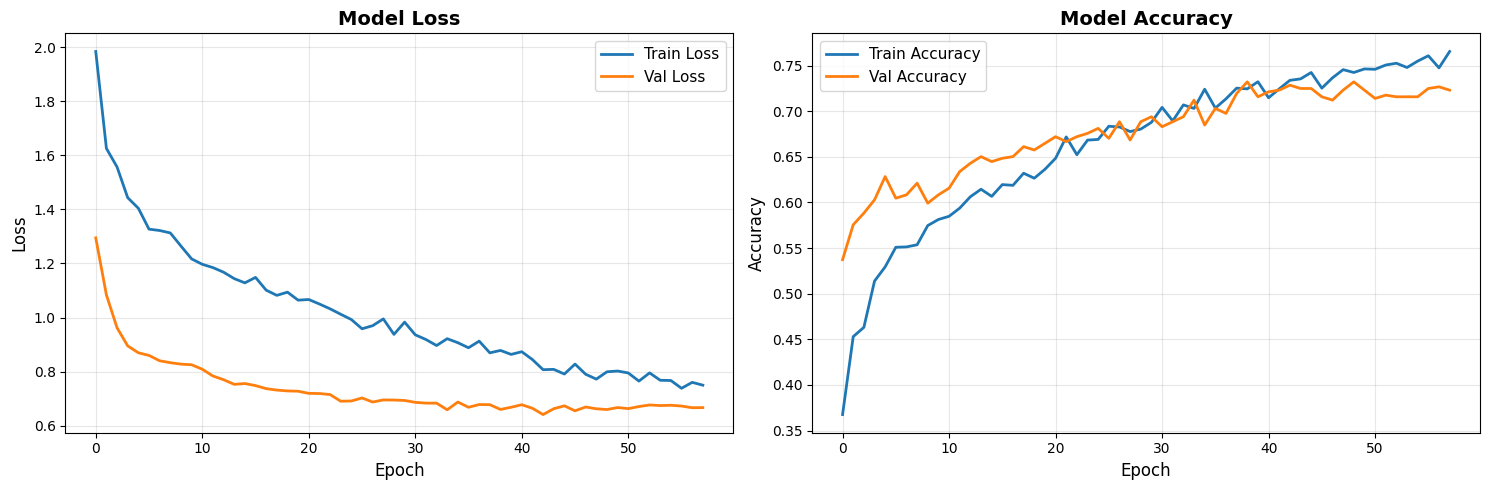


📊 Training Summary:
   Best Train Loss: 0.7383
   Best Val Loss:   0.6411
   Best Train Acc:  0.7655
   Best Val Acc:    0.7322


In [65]:
# ============================================================================
# BAGIAN 9: VISUALIZE TRAINING HISTORY (SAMA, TAPI ADA VAL METRICS!)
# ============================================================================

print("\n" + "="*70)
print("TRAINING HISTORY VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)  # 🔥 Val loss
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)  # 🔥 Val accuracy
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Print best metrics
print(f"\n📊 Training Summary:")
print(f"   Best Train Loss: {min(history.history['loss']):.4f}")
print(f"   Best Val Loss:   {min(history.history['val_loss']):.4f}")
print(f"   Best Train Acc:  {max(history.history['accuracy']):.4f}")
print(f"   Best Val Acc:    {max(history.history['val_accuracy']):.4f}")

In [66]:
# ============================================================================
# 🔥 BAGIAN 11: BAYESIAN INFERENCE - PADA TEST SET!
# ============================================================================

def bayesian_predict(model, data_generator, n_samples=30, verbose=True):
    """Perform Bayesian prediction using Monte Carlo Dropout"""

    print("\n" + "="*70)
    print(f"Performing Bayesian Inference with {n_samples} MC samples...")
    print("="*70)

    all_predictions = []
    all_true_labels = []

    for i in range(len(data_generator)):
        x_batch, y_batch = data_generator[i]

        batch_predictions = []
        for sample_idx in range(n_samples):
            pred = model(x_batch, training=True)
            batch_predictions.append(pred.numpy())

        batch_predictions = np.array(batch_predictions)
        all_predictions.append(batch_predictions)
        all_true_labels.append(y_batch)

        if verbose and (i + 1) % 10 == 0:
            print(f"Processed {i+1}/{len(data_generator)} batches")

    all_predictions = np.concatenate(all_predictions, axis=1)
    all_true_labels = np.vstack(all_true_labels)

    predictions_mean = np.mean(all_predictions, axis=0)
    predictions_std = np.std(all_predictions, axis=0)

    predictive_entropy = -np.sum(
        predictions_mean * np.log(predictions_mean + 1e-10),
        axis=1
    )

    expected_entropy = -np.mean(
        np.sum(all_predictions * np.log(all_predictions + 1e-10), axis=2),
        axis=0
    )

    mutual_information = predictive_entropy - expected_entropy

    pred_classes = np.argmax(predictions_mean, axis=1)
    true_classes = np.argmax(all_true_labels, axis=1)
    confidences = np.max(predictions_mean, axis=1)

    print("\n✅ Bayesian inference completed!")

    return {
        'predictions_mean': predictions_mean,
        'predictions_std': predictions_std,
        'all_predictions': all_predictions,
        'pred_classes': pred_classes,
        'true_classes': true_classes,
        'confidences': confidences,
        'predictive_entropy': predictive_entropy,
        'expected_entropy': expected_entropy,
        'mutual_information': mutual_information,
        'true_labels_onehot': all_true_labels
    }

# 🔥 KUNCI: Bayesian inference pada TEST SET (bukan validation!)
print("\n" + "="*70)
print("BAYESIAN INFERENCE ON TEST SET (FINAL EVALUATION)")
print("="*70)

import tensorflow as tf
model = tf.keras.models.load_model('models/best_bayesian_densenet_v2.h5')
if not model:
    print("Model not found. Please check the file path.")
    exit()

bayesian_results = bayesian_predict(
    model,
    test_data_generator,  # 🔥 GUNAKAN TEST SET!
    n_samples=30,
    verbose=True
)



BAYESIAN INFERENCE ON TEST SET (FINAL EVALUATION)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_10']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)



Performing Bayesian Inference with 30 MC samples...
Processed 10/29 batches
Processed 20/29 batches


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_10']
Received: inputs=Tensor(shape=(7, 224, 224, 3))
  warnings.warn(msg)



✅ Bayesian inference completed!


In [67]:
"""
Script untuk verify model baru sudah benar
Jalankan ini untuk ensure model ready untuk deployment
"""

import numpy as np
from tensorflow import keras
import os

print("="*70)
print("🔍 VERIFYING NEW MODEL: best_bayesian_densenet_v2.h5")
print("="*70)

MODEL_PATH = "models/best_bayesian_densenet_v2.h5"

# ============================================================================
# 1. CHECK FILE EXISTS & SIZE
# ============================================================================
print("\n1️⃣  Checking file...")

if not os.path.exists(MODEL_PATH):
    print(f"❌ ERROR: Model not found at {MODEL_PATH}")
    exit(1)

file_size = os.path.getsize(MODEL_PATH) / (1024 * 1024)  # MB
print(f"✅ Model found!")
print(f"   Size: {file_size:.2f} MB")

if file_size < 80:
    print(f"   ⚠️  WARNING: Size seems small. Expected: 100-150 MB")
elif file_size > 200:
    print(f"   ⚠️  WARNING: Size seems large. Expected: 100-150 MB")
else:
    print(f"   ✅ Size looks good!")

# ============================================================================
# 2. LOAD MODEL
# ============================================================================
print("\n2️⃣  Loading model...")

try:
    model = keras.models.load_model(MODEL_PATH, compile=False)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ Model loaded and compiled!")
except Exception as e:
    print(f"❌ ERROR loading model: {e}")
    exit(1)

# ============================================================================
# 3. CHECK ARCHITECTURE
# ============================================================================
print("\n3️⃣  Checking architecture...")

print(f"   Input shape:  {model.input_shape}")
print(f"   Output shape: {model.output_shape}")
print(f"   Total layers: {len(model.layers)}")

# Check if DenseNet-based
is_densenet = any('densenet' in layer.name.lower() for layer in model.layers)
print(f"   DenseNet-based: {'✅ Yes' if is_densenet else '❌ No'}")

# Check dropout layers
dropout_layers = [layer for layer in model.layers if 'dropout' in layer.name.lower()]
print(f"   Dropout layers: {len(dropout_layers)}")

if model.output_shape[-1] != 5:
    print(f"   ❌ ERROR: Output should be 5 classes, found {model.output_shape[-1]}")
    exit(1)

# ============================================================================
# 4. TEST PREDICTIONS - SHOULD VARY!
# ============================================================================
print("\n4️⃣  Testing predictions (should VARY, not always same class)...")

CLASS_NAMES = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]
np.random.seed(42)

# Generate 10 random test images with different characteristics
test_cases = [
    ('Very Dark', np.random.rand(1, 224, 224, 3).astype(np.float32) * 0.1),
    ('Dark', np.random.rand(1, 224, 224, 3).astype(np.float32) * 0.3),
    ('Medium-Dark', np.random.rand(1, 224, 224, 3).astype(np.float32) * 0.5),
    ('Medium', np.random.rand(1, 224, 224, 3).astype(np.float32) * 0.7),
    ('Bright', np.random.rand(1, 224, 224, 3).astype(np.float32) * 0.9),
    ('Very Bright', np.random.rand(1, 224, 224, 3).astype(np.float32)),
    ('Red-Heavy', np.stack([np.random.rand(224, 224) * 0.9,
                           np.random.rand(224, 224) * 0.3,
                           np.random.rand(224, 224) * 0.3], axis=-1)[None, ...].astype(np.float32)),
    ('Green-Heavy', np.stack([np.random.rand(224, 224) * 0.3,
                             np.random.rand(224, 224) * 0.9,
                             np.random.rand(224, 224) * 0.3], axis=-1)[None, ...].astype(np.float32)),
    ('Blue-Heavy', np.stack([np.random.rand(224, 224) * 0.3,
                            np.random.rand(224, 224) * 0.3,
                            np.random.rand(224, 224) * 0.9], axis=-1)[None, ...].astype(np.float32)),
    ('Uniform', np.ones((1, 224, 224, 3), dtype=np.float32) * 0.5),
]

predictions_summary = []

print("\n   Testing 10 different inputs:")
print("   " + "-"*60)

for name, img in test_cases:
    pred = model.predict(img, verbose=0)
    pred_class = np.argmax(pred[0])
    pred_conf = np.max(pred[0])

    predictions_summary.append(pred_class)

    print(f"   {name:15s} → {CLASS_NAMES[pred_class]:15s} ({pred_conf*100:5.1f}%)")

print("   " + "-"*60)

# ============================================================================
# 5. CHECK PREDICTION DIVERSITY
# ============================================================================
print("\n5️⃣  Checking prediction diversity...")

unique_predictions = len(set(predictions_summary))
most_common_pred = max(set(predictions_summary), key=predictions_summary.count)
most_common_count = predictions_summary.count(most_common_pred)

print(f"   Unique predictions: {unique_predictions}/10")
print(f"   Most common: {CLASS_NAMES[most_common_pred]} ({most_common_count}/10 times)")

if unique_predictions == 1:
    print(f"   ❌ CRITICAL: Model ALWAYS predicts {CLASS_NAMES[most_common_pred]}!")
    print(f"   → Model has collapsed to single class")
    print(f"   → DO NOT USE THIS MODEL")
    exit(1)
elif unique_predictions == 2:
    print(f"   ⚠️  WARNING: Only 2 unique predictions")
    print(f"   → Model might be biased")
elif unique_predictions >= 3:
    print(f"   ✅ Good diversity!")

if most_common_count >= 8:
    print(f"   ⚠️  WARNING: One class dominates ({most_common_count}/10)")
    print(f"   → Model might be biased towards {CLASS_NAMES[most_common_pred]}")

# ============================================================================
# 6. MC DROPOUT TEST
# ============================================================================
print("\n6️⃣  Testing MC Dropout (should show variance)...")

test_img = np.random.rand(1, 224, 224, 3).astype(np.float32)

mc_predictions = []
for i in range(10):
    pred = model(test_img, training=True)
    mc_predictions.append(pred.numpy()[0])

mc_predictions = np.array(mc_predictions)
variance = np.var(mc_predictions, axis=0)
mean_variance = np.mean(variance)

print(f"   Mean variance across iterations: {mean_variance:.6f}")

if mean_variance < 1e-6:
    print(f"   ❌ ERROR: No variance! MC Dropout not working")
    exit(1)
elif mean_variance < 0.001:
    print(f"   ⚠️  Low variance. Dropout might be weak.")
else:
    print(f"   ✅ MC Dropout is working!")

# ============================================================================
# 7. CONFIDENCE DISTRIBUTION TEST
# ============================================================================
print("\n7️⃣  Testing confidence distribution...")

confidences = []
for _ in range(20):
    test_img = np.random.rand(1, 224, 224, 3).astype(np.float32)
    pred = model.predict(test_img, verbose=0)
    confidences.append(np.max(pred[0]))

mean_conf = np.mean(confidences)
std_conf = np.std(confidences)
min_conf = np.min(confidences)
max_conf = np.max(confidences)

print(f"   Mean confidence: {mean_conf:.2%}")
print(f"   Std confidence:  {std_conf:.2%}")
print(f"   Range: {min_conf:.2%} - {max_conf:.2%}")

if mean_conf > 0.95 and std_conf < 0.05:
    print(f"   ⚠️  Model is very overconfident (mean > 95%, low variance)")
elif mean_conf < 0.5:
    print(f"   ⚠️  Model is very underconfident (mean < 50%)")
else:
    print(f"   ✅ Confidence distribution looks reasonable!")

# ============================================================================
# 8. FINAL VERDICT
# ============================================================================
print("\n" + "="*70)
print("📋 FINAL VERDICT")
print("="*70)

issues = []

if file_size < 80:
    issues.append("⚠️  Model file too small")
if not is_densenet:
    issues.append("⚠️  Model might not be DenseNet-based")
if unique_predictions == 1:
    issues.append("❌ CRITICAL: Model collapsed to single class")
if most_common_count >= 9:
    issues.append("⚠️  Model heavily biased to one class")
if mean_variance < 1e-6:
    issues.append("❌ CRITICAL: MC Dropout not working")
if mean_conf > 0.98:
    issues.append("⚠️  Model is overconfident")

if not issues:
    print("\n✅ ✅ ✅  MODEL IS READY FOR DEPLOYMENT! ✅ ✅ ✅")
    print("\nNext steps:")
    print("   1. Run FULL evaluation on test set")
    print("   2. Check per-class metrics")
    print("   3. Update Flask app to use this model")
    print("   4. Test with real fundus images")
elif any("CRITICAL" in issue for issue in issues):
    print("\n❌ ❌ ❌  MODEL HAS CRITICAL ISSUES - DO NOT USE! ❌ ❌ ❌")
    print("\nIssues found:")
    for issue in issues:
        print(f"   {issue}")
    print("\nYou need to RE-TRAIN the model.")
else:
    print("\n⚠️  MODEL HAS SOME ISSUES BUT MIGHT BE USABLE")
    print("\nIssues found:")
    for issue in issues:
        print(f"   {issue}")
    print("\nRecommendation:")
    print("   - Test on FULL test set to verify performance")
    print("   - Consider re-training if issues persist")

print("="*70)

🔍 VERIFYING NEW MODEL: best_bayesian_densenet_v2.h5

1️⃣  Checking file...
✅ Model found!
   Size: 44.30 MB
   ⚠️  WARNING: Size seems small. Expected: 100-150 MB

2️⃣  Loading model...
✅ Model loaded and compiled!

3️⃣  Checking architecture...
   Input shape:  (None, 224, 224, 3)
   Output shape: (None, 5)
   Total layers: 436
   DenseNet-based: ❌ No
   Dropout layers: 3

4️⃣  Testing predictions (should VARY, not always same class)...

   Testing 10 different inputs:
   ------------------------------------------------------------


   Very Dark       → Moderate        ( 35.5%)
   Dark            → Moderate        ( 57.4%)
   Medium-Dark     → Moderate        ( 67.5%)
   Medium          → Moderate        ( 63.7%)
   Bright          → Moderate        ( 69.2%)
   Very Bright     → Moderate        ( 59.9%)
   Red-Heavy       → No_DR           ( 53.1%)
   Green-Heavy     → Moderate        ( 44.5%)
   Blue-Heavy      → Moderate        ( 61.0%)
   Uniform         → No_DR           ( 49.1%)
   ------------------------------------------------------------

5️⃣  Checking prediction diversity...
   Unique predictions: 2/10
   Most common: Moderate (8/10 times)
   ⚠️  WARNING: Only 2 unique predictions
   → Model might be biased
   ⚠️  WARNING: One class dominates (8/10)
   → Model might be biased towards Moderate

6️⃣  Testing MC Dropout (should show variance)...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_10']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


   Mean variance across iterations: 0.000007
   ⚠️  Low variance. Dropout might be weak.

7️⃣  Testing confidence distribution...
   Mean confidence: 57.07%
   Std confidence:  6.69%
   Range: 40.62% - 68.80%
   ✅ Confidence distribution looks reasonable!

📋 FINAL VERDICT

⚠️  MODEL HAS SOME ISSUES BUT MIGHT BE USABLE

Issues found:
   ⚠️  Model file too small
   ⚠️  Model might not be DenseNet-based

Recommendation:
   - Test on FULL test set to verify performance
   - Consider re-training if issues persist



📊 DETAILED PER-CLASS EVALUATION METRICS

1. OVERALL MODEL PERFORMANCE

Metric                    Weighted        Macro          
-------------------------------------------------------
Accuracy                  0.5891 (58.91%)
Precision                 0.5915        0.5914
Recall                    0.5891        0.5890
F1-Score                  0.5670        0.5669
Cohen's Kappa             0.4864
-------------------------------------------------------

2. PER-CLASS PERFORMANCE METRICS

--------------------------------------------------------------------------------
Class           Support    Accuracy     Precision    Recall       F1-Score    
--------------------------------------------------------------------------------
No_DR           181        0.8594 ( 85.9%)  0.5894 ( 58.9%)  0.9834 ( 98.3%)  0.7371 ( 73.7%)
Mild            181        0.8073 ( 80.7%)  0.5176 ( 51.8%)  0.5691 ( 56.9%)  0.5421 ( 54.2%)
Moderate        180        0.7885 ( 78.8%)  0.4522 ( 45.2%)  0.2889 ( 28.9%)  

/tmp/ipython-input-211734036.py:341: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


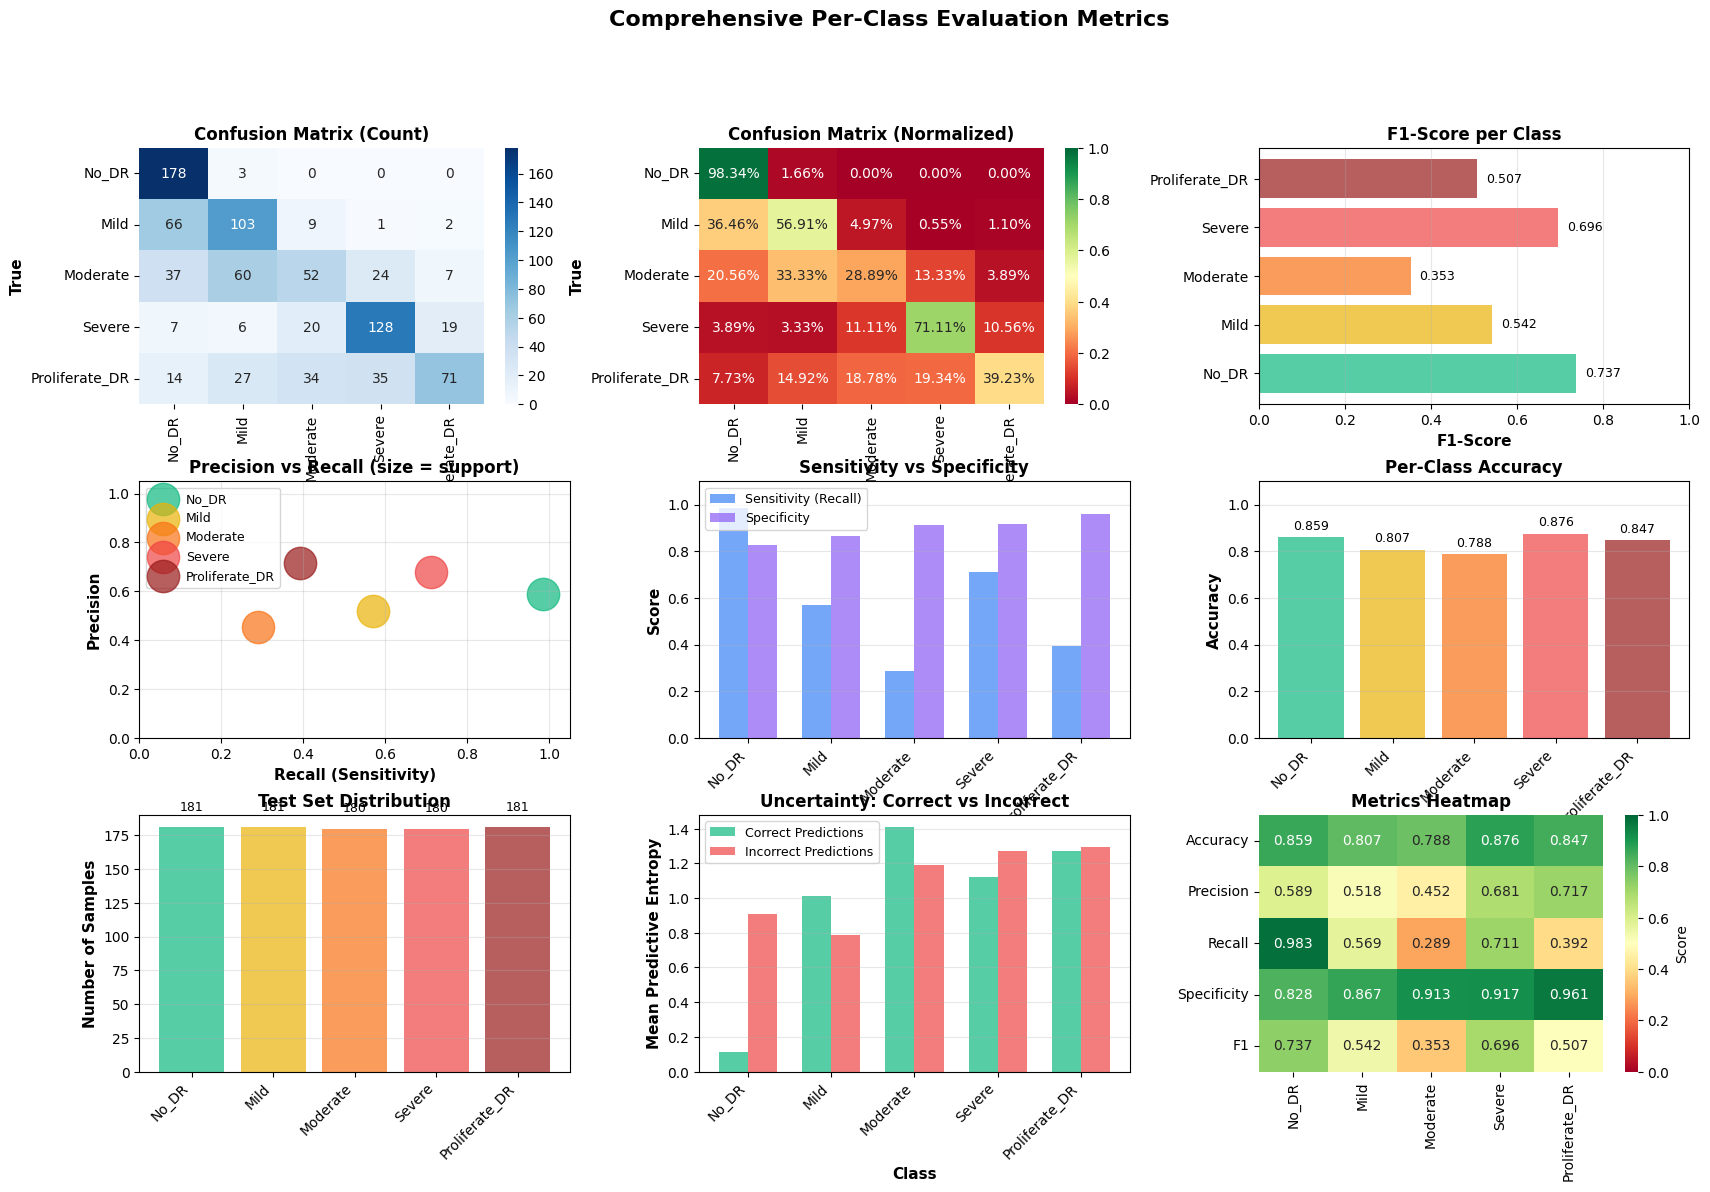

✅ Visualization saved: results/per_class_metrics_comprehensive.png

7. SAVING DETAILED METRICS TO CSV
✅ Saved: results/per_class_detailed_metrics.csv
✅ Saved: results/confusion_matrix.csv

8. MISCLASSIFICATION ANALYSIS

Top 10 Most Common Misclassifications:
----------------------------------------------------------------------
True Class      Predicted As    Count      Percentage  
----------------------------------------------------------------------
Mild            No_DR           66         36.46%
Moderate        Mild            60         33.33%
Moderate        No_DR           37         20.56%
Proliferate_DR  Severe          35         19.34%
Proliferate_DR  Moderate        34         18.78%
Proliferate_DR  Mild            27         14.92%
Moderate        Severe          24         13.33%
Severe          Moderate        20         11.11%
Severe          Proliferate_DR  19         10.56%
Proliferate_DR  No_DR           14         7.73%
--------------------------------------------

In [32]:
# ============================================================================
# 📊 PER-CLASS EVALUATION METRICS & VISUALIZATION
# ============================================================================
# Tambahkan bagian ini SETELAH Bayesian inference pada test set

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score,
    cohen_kappa_score
)

print("\n" + "="*80)
print("📊 DETAILED PER-CLASS EVALUATION METRICS")
print("="*80)

# Class names
CLASS_NAMES = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

# Get predictions and true labels from bayesian_results
y_true = bayesian_results['true_classes']
y_pred = bayesian_results['pred_classes']

# ============================================================================
# 1. OVERALL METRICS
# ============================================================================
print("\n" + "="*80)
print("1. OVERALL MODEL PERFORMANCE")
print("="*80)

overall_accuracy = accuracy_score(y_true, y_pred)
overall_kappa = cohen_kappa_score(y_true, y_pred)

# Calculate weighted metrics
precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)

# Calculate macro metrics
precision_m, recall_m, f1_m, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)

print(f"\n{'Metric':<25} {'Weighted':<15} {'Macro':<15}")
print("-" * 55)
print(f"{'Accuracy':<25} {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"{'Precision':<25} {precision_w:.4f}        {precision_m:.4f}")
print(f"{'Recall':<25} {recall_w:.4f}        {recall_m:.4f}")
print(f"{'F1-Score':<25} {f1_w:.4f}        {f1_m:.4f}")
print(f"{'Cohen\'s Kappa':<25} {overall_kappa:.4f}")
print("-" * 55)

# ============================================================================
# 2. PER-CLASS DETAILED METRICS
# ============================================================================
print("\n" + "="*80)
print("2. PER-CLASS PERFORMANCE METRICS")
print("="*80)

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=range(5), zero_division=0
)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(5))

# Calculate per-class accuracy, specificity, and other metrics
per_class_metrics = []

for i, class_name in enumerate(CLASS_NAMES):
    # True Positives, False Positives, False Negatives, True Negatives
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn

    # Calculate metrics
    class_accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = recall[i]  # Same as recall

    # PPV and NPV
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

    per_class_metrics.append({
        'Class': class_name,
        'Support': int(support[i]),
        'Accuracy': class_accuracy,
        'Precision (PPV)': precision[i],
        'Recall (Sensitivity)': sensitivity,
        'Specificity': specificity,
        'F1-Score': f1[i],
        'NPV': npv,
        'TP': int(tp),
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn)
    })

# Create DataFrame
metrics_df = pd.DataFrame(per_class_metrics)

# Print table
print("\n" + "-"*80)
print(f"{'Class':<15} {'Support':<10} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*80)

for idx, row in metrics_df.iterrows():
    print(f"{row['Class']:<15} {row['Support']:<10} "
          f"{row['Accuracy']:.4f} ({row['Accuracy']*100:5.1f}%)  "
          f"{row['Precision (PPV)']:.4f} ({row['Precision (PPV)']*100:5.1f}%)  "
          f"{row['Recall (Sensitivity)']:.4f} ({row['Recall (Sensitivity)']*100:5.1f}%)  "
          f"{row['F1-Score']:.4f} ({row['F1-Score']*100:5.1f}%)")

print("-"*80)

# ============================================================================
# 3. CONFUSION MATRIX DETAILS PER CLASS
# ============================================================================
print("\n" + "="*80)
print("3. CONFUSION MATRIX BREAKDOWN (TP, TN, FP, FN)")
print("="*80)

print(f"\n{'Class':<15} {'TP':<8} {'TN':<8} {'FP':<8} {'FN':<8} {'Specificity':<12}")
print("-"*70)

for idx, row in metrics_df.iterrows():
    print(f"{row['Class']:<15} {row['TP']:<8} {row['TN']:<8} {row['FP']:<8} {row['FN']:<8} "
          f"{row['Specificity']:.4f} ({row['Specificity']*100:5.1f}%)")

print("-"*70)

# ============================================================================
# 4. CLASSIFICATION REPORT (Scikit-learn)
# ============================================================================
print("\n" + "="*80)
print("4. CLASSIFICATION REPORT (Scikit-learn)")
print("="*80)

print("\n" + classification_report(
    y_true, y_pred,
    target_names=CLASS_NAMES,
    digits=4,
    zero_division=0
))

# ============================================================================
# 5. UNCERTAINTY ANALYSIS PER CLASS
# ============================================================================
print("\n" + "="*80)
print("5. UNCERTAINTY ANALYSIS PER CLASS")
print("="*80)

# Calculate mean uncertainty per class (for correct and incorrect predictions)
uncertainty_per_class = []

for i, class_name in enumerate(CLASS_NAMES):
    # Get samples of this class
    class_mask = y_true == i

    if class_mask.sum() == 0:
        continue

    # Correct and incorrect predictions for this class
    correct_mask = (y_true == i) & (y_pred == i)
    incorrect_mask = (y_true == i) & (y_pred != i)

    # Mean uncertainty
    mean_uncertainty_all = bayesian_results['predictive_entropy'][class_mask].mean()

    if correct_mask.sum() > 0:
        mean_uncertainty_correct = bayesian_results['predictive_entropy'][correct_mask].mean()
    else:
        mean_uncertainty_correct = 0

    if incorrect_mask.sum() > 0:
        mean_uncertainty_incorrect = bayesian_results['predictive_entropy'][incorrect_mask].mean()
    else:
        mean_uncertainty_incorrect = 0

    uncertainty_per_class.append({
        'Class': class_name,
        'Samples': int(class_mask.sum()),
        'Correct': int(correct_mask.sum()),
        'Incorrect': int(incorrect_mask.sum()),
        'Mean Uncertainty': mean_uncertainty_all,
        'Uncertainty (Correct)': mean_uncertainty_correct,
        'Uncertainty (Incorrect)': mean_uncertainty_incorrect,
        'Uncertainty Diff': mean_uncertainty_incorrect - mean_uncertainty_correct
    })

uncertainty_df = pd.DataFrame(uncertainty_per_class)

print(f"\n{'Class':<15} {'Samples':<10} {'Correct':<10} {'Incorrect':<10} {'Mean Unc.':<12} {'Unc. Diff':<12}")
print("-"*80)

for idx, row in uncertainty_df.iterrows():
    print(f"{row['Class']:<15} {row['Samples']:<10} {row['Correct']:<10} {row['Incorrect']:<10} "
          f"{row['Mean Uncertainty']:.4f}      {row['Uncertainty Diff']:+.4f}")

print("-"*80)
print("\n💡 Interpretation:")
print("   - Higher 'Uncertainty Diff' = Model is more uncertain on incorrect predictions (Good!)")
print("   - Lower 'Mean Uncertainty' = Model is more confident overall for this class")

# ============================================================================
# 6. VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("6. GENERATING VISUALIZATIONS")
print("="*80)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 6.1 Confusion Matrix (Count)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax1)
ax1.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax1.set_ylabel('True', fontsize=11, fontweight='bold')
ax1.set_title('Confusion Matrix (Count)', fontsize=12, fontweight='bold')

# 6.2 Confusion Matrix (Normalized)
ax2 = fig.add_subplot(gs[0, 1])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax2, vmin=0, vmax=1)
ax2.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax2.set_ylabel('True', fontsize=11, fontweight='bold')
ax2.set_title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')

# 6.3 Per-Class F1-Score
ax3 = fig.add_subplot(gs[0, 2])
colors = ['#10b981', '#eab308', '#f97316', '#ef4444', '#991b1b']
bars = ax3.barh(CLASS_NAMES, metrics_df['F1-Score'], color=colors, alpha=0.7)
ax3.set_xlabel('F1-Score', fontsize=11, fontweight='bold')
ax3.set_title('F1-Score per Class', fontsize=12, fontweight='bold')
ax3.set_xlim(0, 1)
ax3.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, metrics_df['F1-Score'])):
    ax3.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=9)

# 6.4 Precision vs Recall
ax4 = fig.add_subplot(gs[1, 0])
for i, class_name in enumerate(CLASS_NAMES):
    ax4.scatter(metrics_df.iloc[i]['Recall (Sensitivity)'],
               metrics_df.iloc[i]['Precision (PPV)'],
               s=metrics_df.iloc[i]['Support']*3,
               color=colors[i],
               alpha=0.7,
               label=class_name)
ax4.set_xlabel('Recall (Sensitivity)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax4.set_title('Precision vs Recall (size = support)', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 1.05)
ax4.set_ylim(0, 1.05)

# 6.5 Sensitivity vs Specificity
ax5 = fig.add_subplot(gs[1, 1])
x_pos = np.arange(len(CLASS_NAMES))
width = 0.35
bars1 = ax5.bar(x_pos - width/2, metrics_df['Recall (Sensitivity)'],
                width, label='Sensitivity (Recall)', color='#3b82f6', alpha=0.7)
bars2 = ax5.bar(x_pos + width/2, metrics_df['Specificity'],
                width, label='Specificity', color='#8b5cf6', alpha=0.7)
ax5.set_xlabel('Class', fontsize=11, fontweight='bold')
ax5.set_ylabel('Score', fontsize=11, fontweight='bold')
ax5.set_title('Sensitivity vs Specificity', fontsize=12, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
ax5.legend(fontsize=9)
ax5.grid(axis='y', alpha=0.3)
ax5.set_ylim(0, 1.1)

# 6.6 Per-Class Accuracy
ax6 = fig.add_subplot(gs[1, 2])
bars = ax6.bar(CLASS_NAMES, metrics_df['Accuracy'], color=colors, alpha=0.7)
ax6.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax6.set_title('Per-Class Accuracy', fontsize=12, fontweight='bold')
ax6.set_ylim(0, 1.1)
ax6.grid(axis='y', alpha=0.3)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')
for bar, val in zip(bars, metrics_df['Accuracy']):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# 6.7 Sample Distribution
ax7 = fig.add_subplot(gs[2, 0])
bars = ax7.bar(CLASS_NAMES, metrics_df['Support'], color=colors, alpha=0.7)
ax7.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax7.set_title('Test Set Distribution', fontsize=12, fontweight='bold')
ax7.grid(axis='y', alpha=0.3)
plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45, ha='right')
for bar, val in zip(bars, metrics_df['Support']):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + 10,
            f'{int(val)}', ha='center', va='bottom', fontsize=9)

# 6.8 Uncertainty per Class
ax8 = fig.add_subplot(gs[2, 1])
x_pos = np.arange(len(CLASS_NAMES))
width = 0.35
bars1 = ax8.bar(x_pos - width/2, uncertainty_df['Uncertainty (Correct)'],
                width, label='Correct Predictions', color='#10b981', alpha=0.7)
bars2 = ax8.bar(x_pos + width/2, uncertainty_df['Uncertainty (Incorrect)'],
                width, label='Incorrect Predictions', color='#ef4444', alpha=0.7)
ax8.set_xlabel('Class', fontsize=11, fontweight='bold')
ax8.set_ylabel('Mean Predictive Entropy', fontsize=11, fontweight='bold')
ax8.set_title('Uncertainty: Correct vs Incorrect', fontsize=12, fontweight='bold')
ax8.set_xticks(x_pos)
ax8.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
ax8.legend(fontsize=9)
ax8.grid(axis='y', alpha=0.3)

# 6.9 Metrics Heatmap
ax9 = fig.add_subplot(gs[2, 2])
metrics_heatmap = metrics_df[['Accuracy', 'Precision (PPV)', 'Recall (Sensitivity)',
                               'Specificity', 'F1-Score']].values.T
sns.heatmap(metrics_heatmap, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=CLASS_NAMES,
            yticklabels=['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1'],
            ax=ax9, vmin=0, vmax=1, cbar_kws={'label': 'Score'})
ax9.set_title('Metrics Heatmap', fontsize=12, fontweight='bold')

plt.suptitle('Comprehensive Per-Class Evaluation Metrics',
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('results/per_class_metrics_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: results/per_class_metrics_comprehensive.png")

# ============================================================================
# 7. SAVE DETAILED RESULTS TO CSV
# ============================================================================
print("\n" + "="*80)
print("7. SAVING DETAILED METRICS TO CSV")
print("="*80)

# Merge metrics and uncertainty DataFrames
detailed_results = pd.merge(metrics_df, uncertainty_df, on='Class')

# Save to CSV
detailed_results.to_csv('results/per_class_detailed_metrics.csv', index=False)
print("✅ Saved: results/per_class_detailed_metrics.csv")

# Also save confusion matrix
cm_df = pd.DataFrame(cm,
                     index=[f'True_{c}' for c in CLASS_NAMES],
                     columns=[f'Pred_{c}' for c in CLASS_NAMES])
cm_df.to_csv('results/confusion_matrix.csv')
print("✅ Saved: results/confusion_matrix.csv")

# ============================================================================
# 8. MISCLASSIFICATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("8. MISCLASSIFICATION ANALYSIS")
print("="*80)

# Find most common misclassifications
misclassifications = []
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        if i != j and cm[i, j] > 0:
            misclassifications.append({
                'True Class': CLASS_NAMES[i],
                'Predicted As': CLASS_NAMES[j],
                'Count': int(cm[i, j]),
                'Percentage': cm[i, j] / cm[i, :].sum() * 100
            })

if misclassifications:
    misclass_df = pd.DataFrame(misclassifications)
    misclass_df = misclass_df.sort_values('Count', ascending=False)

    print("\nTop 10 Most Common Misclassifications:")
    print("-"*70)
    print(f"{'True Class':<15} {'Predicted As':<15} {'Count':<10} {'Percentage':<12}")
    print("-"*70)

    for idx, row in misclass_df.head(10).iterrows():
        print(f"{row['True Class']:<15} {row['Predicted As']:<15} "
              f"{row['Count']:<10} {row['Percentage']:.2f}%")

    print("-"*70)

    # Save to CSV
    misclass_df.to_csv('results/misclassifications.csv', index=False)
    print("\n✅ Saved: results/misclassifications.csv")
else:
    print("\n✅ Perfect classification! No misclassifications found.")

# ============================================================================
# 9. SUMMARY STATISTICS
# ============================================================================
print("\n" + "="*80)
print("9. SUMMARY STATISTICS")
print("="*80)

summary = {
    'Total Samples': len(y_true),
    'Correctly Classified': int((y_true == y_pred).sum()),
    'Misclassified': int((y_true != y_pred).sum()),
    'Overall Accuracy': f"{overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)",
    'Weighted Precision': f"{precision_w:.4f}",
    'Weighted Recall': f"{recall_w:.4f}",
    'Weighted F1-Score': f"{f1_w:.4f}",
    'Macro Precision': f"{precision_m:.4f}",
    'Macro Recall': f"{recall_m:.4f}",
    'Macro F1-Score': f"{f1_m:.4f}",
    'Cohen\'s Kappa': f"{overall_kappa:.4f}",
    'Best Performing Class': CLASS_NAMES[metrics_df['F1-Score'].idxmax()],
    'Worst Performing Class': CLASS_NAMES[metrics_df['F1-Score'].idxmin()],
    'Most Uncertain Class': CLASS_NAMES[uncertainty_df['Mean Uncertainty'].idxmax()],
    'Least Uncertain Class': CLASS_NAMES[uncertainty_df['Mean Uncertainty'].idxmin()]
}

print("\n📊 Model Performance Summary:")
print("-"*70)
for key, value in summary.items():
    print(f"{key:<30} : {value}")
print("-"*70)

# Save summary
import json
with open('results/evaluation_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)

print("\n✅ Saved: results/evaluation_summary.json")

print("\n" + "="*80)
print("✅ PER-CLASS EVALUATION COMPLETE!")
print("="*80)
print("\nGenerated Files:")
print("   1. results/per_class_metrics_comprehensive.png")
print("   2. results/per_class_detailed_metrics.csv")
print("   3. results/confusion_matrix.csv")
print("   4. results/misclassifications.csv")
print("   5. results/evaluation_summary.json")
print("="*80)